# Classification with stumbleupon data

Project 4 has been changed since scraping was untenable. The project now focuses on the stumbleupon kaggle dataset. For more information on this dataset, [check out the website here](https://www.kaggle.com/c/stumbleupon).

---

# Table of Contents

1. [Cleaning and EDA](#eda)  
    1.1 [Dropping Rows](#nan)  
    1.2 [Pairplot](#pairplot)
2. [Data Dictionary](#datadict)
3. [Regression](#reggresion)  
    3.1 [StatsModel Logistic Regression](#statsmodels logreg)  
    3.2 [Category Logistic Regression](#categorylr)  
4. [GridSearch](#gridsearch)  
    4.2 [LogReg with Optimal Parameters](#optparam)  
    4.3 [Precision Focused Optimal Parameters](#gridpre)  
5. [Bonus](#bonus)  
    5.1 [Pipeline](#pipe)  
    5.2 [Top 25 Title Words](#top25)  
    
Additionally:
[medium](#www.medium.com/@sambozek)

## 1. Load in the dataset

This is the only part completed for you.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

%matplotlib inline

In [2]:
su = pd.read_csv('../dataset/evergreen.tsv', delimiter='\t')
su.shape

(7395, 27)

## 2. Clean up/examine your data
<a id="eda"></a>

Some of the columns may have values that need changing or that are of the wrong type. There could also be columns that aren't very useful.

---

In [3]:
su.head(2)

url  urlid  \
0  http://www.bloomberg.com/news/2010-12-23/ibm-p...   4042   
1  http://www.popsci.com/technology/article/2012-...   8471   

                                         boilerplate alchemy_category  \
0  {"title":"IBM Sees Holographic Calls Air Breat...         business   
1  {"title":"The Fully Electronic Futuristic Star...       recreation   

  alchemy_category_score  avglinksize  commonlinkratio_1  commonlinkratio_2  \
0               0.789131     2.055556           0.676471           0.205882   
1               0.574147     3.677966           0.508021           0.288770   

   commonlinkratio_3  commonlinkratio_4  ...    is_news  lengthyLinkDomain  \
0           0.047059           0.023529  ...          1                  1   
1           0.213904           0.144385  ...          1                  1   

   linkwordscore  news_front_page  non_markup_alphanum_characters  \
0             24                0                            5424   
1             40                0                            4973   

   numberOfLinks  numwords_in_url parametrizedLinkRatio  \
0            170                8              0.152941   
1            187                9              0.181818   

   spelling_errors_ratio  label  
0               0.079130      0  
1               0.125448      1  

[2 rows x 27 columns]

In [4]:
su.alchemy_category.unique()

array(['business', 'recreation', 'health', 'sports', '?',
       'arts_entertainment', 'science_technology', 'gaming',
       'culture_politics', 'computer_internet', 'law_crime', 'religion',
       'weather', 'unknown'], dtype=object)

---
<a id="nan"></a>
*From above two categories that are ready to be dropped are the '?' and the 'unknown' categories, with the first not having been assigned by the alchemyapi, and the other being a category that is not classified by the model, and both will be dropped since they don't have any value for modeling*

---

In [5]:
su['alchemy_category'] = su['alchemy_category'].apply(lambda x: np.NaN if (x == '?' or x == 'unknown') else x) # drop all 
su.dropna(axis=0, how='any', inplace=True)
su['alchemy_category_score'] = pd.to_numeric(su['alchemy_category_score'])
su.shape

(5047, 27)

## Data Dictionary
<a id="datadict"></a>

|Column Name|Description|Variable Type|
|---|---|--|
|url|URL of the recommended website|Categorical|
|urlid|Unique StumbleUpon ID assigned to the URL|Ordinal|
|boilerplate|JSON file containing the text of the title and the text of the body|Categorical|
|alchemy_category|Category of the website assigned through AlchemyAPI|Categorical|
|alchemy_category_score|Score from 1(best) to 0(worst) of the confidence of the AlchemyAPI in assigning the category|Interval|
|avglinksize|Mean number of words that appear in all the links present on the wepsite|Cardinal|
|commonLinkRatio_(1-4)| The number of links sharing at least one word in common with x other links divided by total number of links|Interval|
|compression_ratio|Ratio of compressed size of website to uncompressed size (using gzip)|Interval|
|embed_ratio| Ratio of how many times HTML embed element appears relative to other elements|Interval|
|frameBased|Whether or not a website is using a frameset markup(1) or a body(0)|Categorical|
|frameTagRatio|Ratio of frames to markup|Interval|
|hasDomainLink|Whether(1) or not(0) the website has a link to a domain|Categorical|
|html_ratio|How many tags are present to total text span on the website|Interval|
|image_ratio|Ratio of <img> tags to total text span on the website|Interval|
|is_news|Whether(1) or not(0) the website is categorized as news|Categorical|
|lengthyLinkDomain|Whether(1) or not(0) at least three links contain >30 characters|Categorical|
|linkwordscore|Ratio of words on page to the hyperlink text|Interval|
|news_front_page|Whether(1) or not(0) the news is considered significant 'front page'|Categorical|
|non_markup_alphanum_characters|Total number of characters in the text of the website|Ordinal|
|numberOfLinks|Count of how many links are present|Ordinal
|numwords_in_url|Count of words in the URL|Ordinal|
|parametrizedLinkRatio|Ratio of links with an event on the click or additonal parameter to all other links|Interval|
|spelling_errors_ratio|Ratio of words classified as misspelled to all text present|Interval|
|label| **TARGET** Whether(1) or not(0) the website is considered 'evergreen'|Categorical|


## QUESTIONS
* What makes evergreen news stories? Are there any?
* Does AlchemyAPI score play into whether it is evergreen?
* Is FrameSet or Body more likely to be evergreen?
* Are there evergreen front page news stories? What text do they contain?

In [6]:
su.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5047 entries, 0 to 7393
Data columns (total 27 columns):
url                               5047 non-null object
urlid                             5047 non-null int64
boilerplate                       5047 non-null object
alchemy_category                  5047 non-null object
alchemy_category_score            5047 non-null float64
avglinksize                       5047 non-null float64
commonlinkratio_1                 5047 non-null float64
commonlinkratio_2                 5047 non-null float64
commonlinkratio_3                 5047 non-null float64
commonlinkratio_4                 5047 non-null float64
compression_ratio                 5047 non-null float64
embed_ratio                       5047 non-null float64
framebased                        5047 non-null int64
frameTagRatio                     5047 non-null float64
hasDomainLink                     5047 non-null int64
html_ratio                        5047 non-null float64
image_

<a id="pairplot"></a>

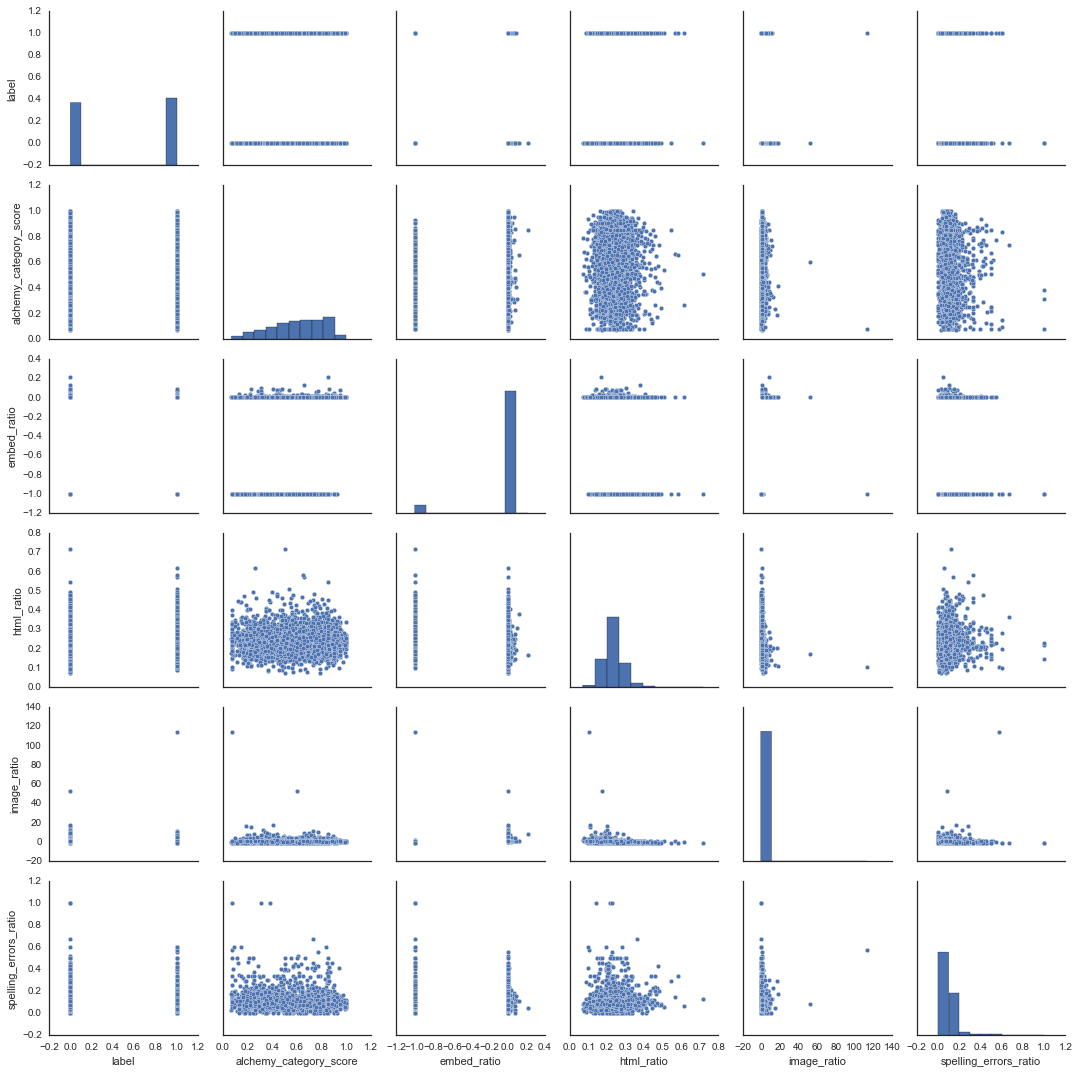

In [7]:
sns.pairplot(su[['label','alchemy_category_score',
   'embed_ratio', 'html_ratio', 'image_ratio', 'spelling_errors_ratio']])

*Through looking at the description of the variables present, certain items related to the URL are likely not important to the regression at hand. Because of the nature of stumbleupon, the URL itself and associated identifiers are likely not that important*
*Additional issue is that there are certain values that are negative in the dataframe. Using a describe can determine which sections have negative values*

In [8]:
su.describe()

urlid  alchemy_category_score  avglinksize  commonlinkratio_1  \
count   5047.000000             5047.000000  5047.000000        5047.000000   
mean    5312.421438                0.603576     2.941677           0.463808   
std     3062.929042                0.212875    10.142588           0.198609   
min        5.000000                0.070833     0.000000           0.000000   
25%     2651.500000                0.453046     1.620471           0.343750   
50%     5309.000000                0.626056     2.106557           0.476190   
75%     7984.000000                0.780938     2.681887           0.607086   
max    10566.000000                0.999426   363.000000           1.000000   

       commonlinkratio_2  commonlinkratio_3  commonlinkratio_4  \
count        5047.000000        5047.000000        5047.000000   
mean            0.213716           0.091592           0.049572   
std             0.144047           0.093390           0.071395   
min             0.000000           0.000000           0.000000   
25%             0.108245           0.023015           0.000000   
50%             0.202381           0.069444           0.024523   
75%             0.296601           0.132805           0.066667   
max             1.000000           0.980392           0.980392   

       compression_ratio  embed_ratio  framebased     ...        html_ratio  \
count        5047.000000  5047.000000      5047.0     ...       5047.000000   
mean            1.378695    -0.060109         0.0     ...          0.234638   
std             4.116507     0.239295         0.0     ...          0.051471   
min             0.000000    -1.000000         0.0     ...          0.070094   
25%             0.440828     0.000000         0.0     ...          0.202506   
50%             0.479209     0.000000         0.0     ...          0.230641   
75%             0.547089     0.000000         0.0     ...          0.260774   
max            21.000000     0.214286         0.0     ...          0.716883   

       image_ratio  lengthyLinkDomain  linkwordscore  \
count  5047.000000        5047.000000    5047.000000   
mean      0.290548           0.672875      30.031306   
std       1.969217           0.469210      20.067331   
min      -1.000000           0.000000       0.000000   
25%       0.032383           0.000000      14.000000   
50%       0.088050           1.000000      26.000000   
75%       0.239583           1.000000      43.000000   
max     113.333333           1.000000     100.000000   

       non_markup_alphanum_characters  numberOfLinks  numwords_in_url  \
count                     5047.000000    5047.000000      5047.000000   
mean                      5443.990886     178.797107         5.059441   
std                       7029.922055     154.575580         3.267447   
min                          0.000000       1.000000         0.000000   
25%                       1611.500000      82.000000         3.000000   
50%                       3633.000000     141.000000         5.000000   
75%                       6420.500000     228.000000         7.000000   
max                      87948.000000    3283.000000        21.000000   

       parametrizedLinkRatio  spelling_errors_ratio        label  
count            5047.000000            5047.000000  5047.000000  
mean                0.171025               0.097220     0.518724  
std                 0.176426               0.060434     0.499699  
min                 0.000000               0.000000     0.000000  
25%                 0.044071               0.069560     0.000000  
50%                 0.116505               0.089069     1.000000  
75%                 0.237648               0.110507     1.000000  
max                 1.000000               1.000000     1.000000  

[8 rows x 22 columns]

In [9]:
len(su[su['image_ratio']==0])


29

*The embed ratio have values of -1 which is not possible. In order to determine how imputation will be done, a distribution of them will be made. Since the distribution is unknown, it may be skewed which would be problematic in imputing the mean, since it would be away from the median.*

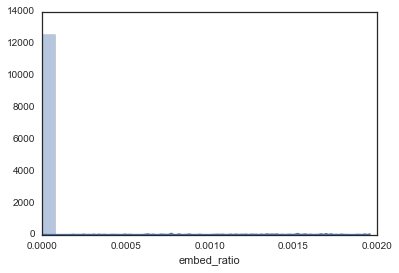

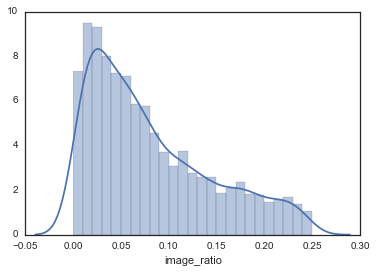

In [10]:
lim_su_em = su[(su['embed_ratio'] > -1) & (su['embed_ratio'] < 0.002)] 
lim_su_im = su[(su['image_ratio'] > - 1) & (su['image_ratio'] < 0.25)]
# lim_su_em.info()

sns.distplot(lim_su_em['embed_ratio'],bins=25)
plt.xlim([0,0.002])
plt.show()
sns.distplot(lim_su_im['image_ratio'],bins=25)
plt.show()

---

*Embed ratio has a very low value, and can be easily imputed from the mean that can be found when the -1 values are ignored*

*Image ratio has a positive skew, and can't have the mean be used as the assignment. Since this was taken over all values, additional resolution will be obtained by looking at all of the alchemy score categories on their own (ignoring unassigned). Then seeing their individual distribution. If it is a normal distribution this means that the median or mean can be used in imputing.*

---

business


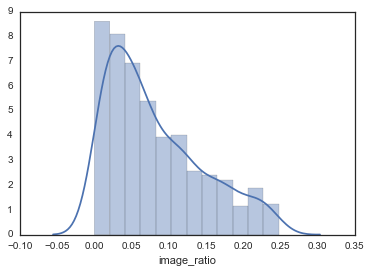

recreation


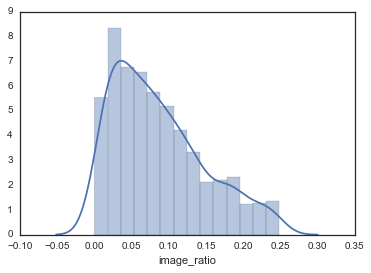

health


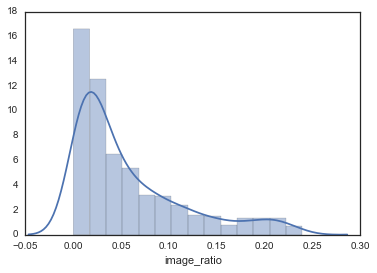

sports


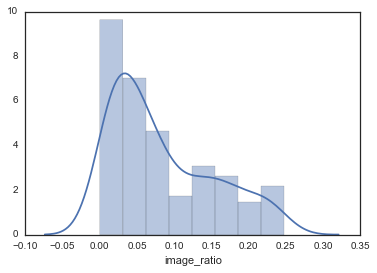

arts_entertainment


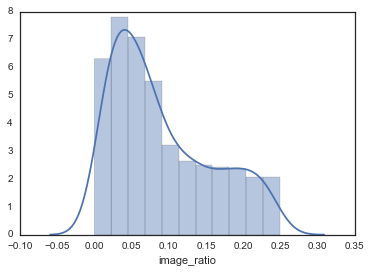

science_technology


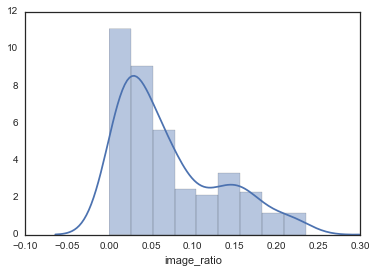

gaming


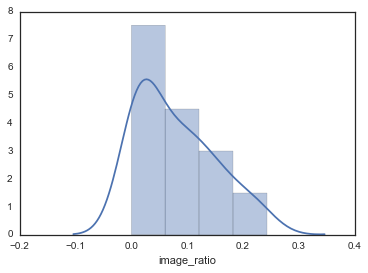

culture_politics


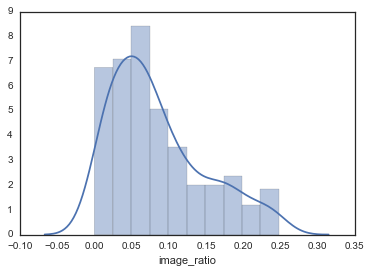

computer_internet


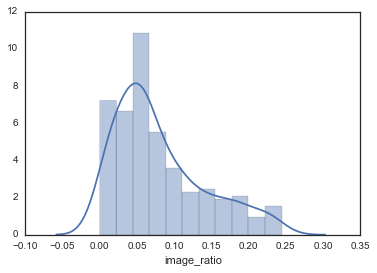

religion


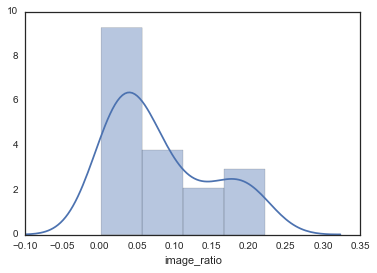

law_crime


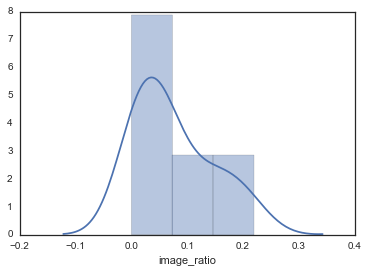

In [11]:
unique_cat = lim_su_im['alchemy_category'].unique()

unique_cat = list(unique_cat) # convert from ndarray

lim_su_im['alchemy_category'].value_counts() # Weather has only one item, need to remove

unique_cat.remove('weather') # remove weather from unique categories list

for cat in unique_cat: # iterate through categories
    print cat
    sns.distplot(lim_su_im['image_ratio'][lim_su_im['alchemy_category'] == cat])
    plt.show() # Show the associated plot

*All categories above had skews that would not make them appropriate for imputation until after they had been normalized.*

## 3. Use statsmodels' logistic regression function to look at variable significance
<a id="statsmodels logreg"></a>

The **`import statsmodels.formula.api as smf`** code below gives us access to a statsmodels api that can run logistic regressions using patsy-style formulas.

Ex:

```python
formula = 'target ~ var1 + var2 + C(var3) -1'
logreg = smf.logit(formula, data=data)
logreg_results = logreg.fit()
print logreg_results.summary()
```

---

In [12]:
# Import appropriate pacakges
import statsmodels.formula.api as smf
import patsy

In [13]:
# Create Formula
formula = 'label ~ html_ratio + image_ratio + embed_ratio + frameTagRatio +parametrizedLinkRatio + spelling_errors_ratio + numberOfLinks - 1' # -1 used to remove the intercept

In [14]:
logr = smf.logit(formula, data=su) # Perform Logit function on provided formula

In [15]:
logr_result = logr.fit()           # Fit the model

Optimization terminated successfully.
         Current function value: 0.668724
         Iterations 5


In [16]:
print logr_result.summary()       # Print out the summary results from the regression

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 5047
Model:                          Logit   Df Residuals:                     5040
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 May 2016   Pseudo R-squ.:                 0.03426
Time:                        20:29:50   Log-Likelihood:                -3375.0
converged:                       True   LL-Null:                       -3494.8
                                        LLR p-value:                 7.353e-49
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
html_ratio                3.3375      0.338      9.875      0.000         2.675     4.000
image_ratio              -0.0095      0.018     -0.537      0.591        -0.044     0.025
embed_ra

### 3.1 Run a logistic regression predicting evergreen from the numeric columns

And print out the results as shown in the example above.

---

In [17]:
formula = '''label ~ alchemy_category_score + avglinksize + compression_ratio + 
            embed_ratio + frameTagRatio + html_ratio + image_ratio
            + avglinksize+ commonlinkratio_1+commonlinkratio_2+
            commonlinkratio_3 + commonlinkratio_4'''


In [18]:
logreg = smf.logit(formula, data=su)

In [19]:
model = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.663870
         Iterations 5


In [20]:
print model.summary()

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 5047
Model:                          Logit   Df Residuals:                     5035
Method:                           MLE   Df Model:                           11
Date:                Sun, 15 May 2016   Pseudo R-squ.:                 0.04127
Time:                        20:29:50   Log-Likelihood:                -3350.6
converged:                       True   LL-Null:                       -3494.8
                                        LLR p-value:                 2.371e-55
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0.9731      0.191      5.099      0.000         0.599     1.347
alchemy_category_score    -0.8426      0.140     -6.012      0.000        -1.117    -0.568
avgl

### 3.2 Run a logistic regression predicting evergreen from the numeric columns and a categorical variable of alchemy_category

And print out the results as shown in the example.

---

In [21]:
formula = '''label ~ C(alchemy_category) + alchemy_category_score + avglinksize + 
compression_ratio + embed_ratio + 
frameTagRatio + html_ratio + image_ratio - 1'''

In [22]:
logreg = smf.logit(formula, data=su)
model = logreg.fit()

         Current function value: 0.610176
         Iterations: 35


/Users/sebozek/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
print model.summary()

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 5047
Model:                          Logit   Df Residuals:                     5028
Method:                           MLE   Df Model:                           18
Date:                Sun, 15 May 2016   Pseudo R-squ.:                  0.1188
Time:                        20:29:50   Log-Likelihood:                -3079.6
converged:                      False   LL-Null:                       -3494.8
                                        LLR p-value:                1.053e-164
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
C(alchemy_category)[arts_entertainment]     0.0731      0.190      0.385      0.700        -0.299     0.445
C(alchemy_category)[business]               

## 4. Use sklearn to cross-validate the accuracy of the model above

Normalize the numeric and categorical columns of the predictor matrix.

---

In [24]:
from sklearn.linear_model import LogisticRegressionCV
# use logistic regression with cross validation


not_target = [x for x in su if x not in ['label', 'is_news', 'url',
                                         'urlid','boilerplate',
                                        'alchemy_category', 
                                         'news_front_page', 'title']] # Isolate all of the numeric columns
su_n = su.copy()
su_n.ix[:, not_target] = (su_n.ix[:, not_target] -  # Could have used StandardScalar, but wanted to be transparent
                          su_n.ix[:, not_target].mean()) / su_n.ix[:, not_target].std()

In [25]:
logreg = LogisticRegressionCV(Cs=3, # Inverse of regularization strength. Chose 3 for slightly strong regularization
                              cv=7)   # Set model with 7 stratified k-folds

In [26]:
Y, X = patsy.dmatrices('''label ~ C(alchemy_category) + alchemy_category_score + avglinksize + 
compression_ratio + embed_ratio + 
frameTagRatio + html_ratio + image_ratio - 1''', data=su_n)

Y = np.ravel(Y) # Change Y to 1D array

logreg.fit(X,Y) # fit to the logistic 

LogisticRegressionCV(Cs=3, class_weight=None, cv=7, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [27]:
logreg.scores_[1]

array([[ 0.54923717,  0.64909847,  0.64909847],
       [ 0.54507628,  0.68932039,  0.68932039],
       [ 0.5409154 ,  0.65880721,  0.66019417],
       [ 0.55062413,  0.66574202,  0.66574202],
       [ 0.5631068 ,  0.67267684,  0.67267684],
       [ 0.55755895,  0.67961165,  0.67961165],
       [ 0.55755895,  0.66851595,  0.66851595]])

## 5. Gridsearch regularization parameters for logistic regression

Find the best regularization type (Ridge, Lasso) across a set of regularization strengths.

[NOTE: C is the inverse of the regularization strength. Lower C values are stronger regularization. Having a C higher than 1 will significantly slow down the search. I'm not particularly interested in values over 1, since this is the default regularization strength in LogisticRegression.]

**After you find the best set of parameters, build a Logistic Regression with those parameters and crossvalidate the score.**

[NOTE 2: to run Lasso regularization the solver should be `'liblinear'`]

---

In [28]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

Cs = [0.1, 2, 20]
log = LogisticRegression()

search_parameters = {
    "penalty":             ['l1','l2'],        # Used to specify the norm used in the penalization.
    "C":                   Cs,                 # Regularization paramter
    "fit_intercept":       [False, True],      # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    "class_weight":        [None, "balanced"], # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    "intercept_scaling":   [2, 1],             # Useful only if solver is liblinear. when self.fit_intercept is True, instance vector x becomes [x, self.intercept_scaling], i.e. a “synthetic” feature with constant value equals to intercept_scaling is appended to the instance vector. 
    "solver":              ['liblinear'],      # Set the solver to be liblinear
    # Because LibLinear solver is being used the warm start is not needed
}

searcher = GridSearchCV(log, search_parameters)

In [29]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [30]:
searcher.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 2, 20], 'intercept_scaling': [2, 1], 'solver': ['liblinear'], 'fit_intercept': [False, True], 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [31]:
print "Best C / Regularization Param:", searcher.best_estimator_.C # This estimator.best_estimator_ object has many great reporting metrics
print "Best Params:", searcher.best_params_
print "Best Score:", searcher.best_score_

Best C / Regularization Param: 0.1
Best Params: {'C': 0.1, 'intercept_scaling': 1, 'fit_intercept': True, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}
Best Score: 0.672706681767


In [32]:
y_true, y_pred = y_test, searcher.predict(x_test)
print classification_report(y_true, y_pred, target_names=["Not Evergreen", "Evergreen"])

               precision    recall  f1-score   support

Not Evergreen       0.66      0.64      0.65       756
    Evergreen       0.65      0.67      0.66       759

  avg / total       0.65      0.65      0.65      1515



## 6. Gridsearch neighbors for kNN

Find the best number of neighbors with your predictors to predict the `label` target variable.

Start by bulding a kNN model with a set number of neighbors, then use gridsearch to run through a series of neighbors.

---

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
# Using KNN parameters set up variety of tests
params = {
    'n_neighbors' : [3,125],  # Go between 3 to 125 neighbor tests
    
    'weights' : ("uniform",   # All neighbors have equal weight
                 "distance"), # Neighbors contribution are weighted by 1/d (closer have more weight)
    
    'algorithm' : ("ball_tree", # Alg used in high dimensional nearest-neighbor, 
                                # partitions nearby points into nests of "balls" in high dimensional space
                   
                  "kd_tree",    # Alg that creates binary space partitioning through continued splits in high dimensional space
                   
                  "brute",      # Use a brute force search for assignment
                  "auto"),      # Tries to determine the most appropriate method to use based on fit parameters
    
    'p' : [1,  # p=1 is Manhattan distance (l1)
          2]   # p=2 is Euclidian distance (l2)
}

In [35]:
KNN = KNeighborsClassifier() # Prepare the KNN classifier

# Set up grid search with above parameters and k-nearest algorithm
grid_KNN = GridSearchCV(KNN, params) 

In [36]:
# Use the same train_test split as in the Logistic Regression
# Grid Search that was done previously.

grid_KNN.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 125], 'weights': ('uniform', 'distance'), 'algorithm': ('ball_tree', 'kd_tree', 'brute', 'auto'), 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [37]:
print "Best Estimator:", grid_KNN.best_estimator_.n_neighbors
print "Best Params:", grid_KNN.best_params_
print "Best Score:", grid_KNN.best_score_

Best Estimator: 125
Best Params: {'n_neighbors': 125, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1}
Best Score: 0.681483578709


In [38]:
y_pred = grid_KNN.predict(x_test)

print classification_report(y_test, y_pred, target_names=["Not Evergreen", "Evergreen"])

               precision    recall  f1-score   support

Not Evergreen       0.72      0.56      0.63       756
    Evergreen       0.64      0.78      0.70       759

  avg / total       0.68      0.67      0.67      1515



## 7. Choose a new target from alchemy_category to predict with logistic regression

**Ideally your category choice will have a small fraction of the total rows, but not TOO small!**

---

In [39]:
su['alchemy_category'].value_counts()

recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
weather                  4
Name: alchemy_category, dtype: int64

In [40]:
unique_cat = su['alchemy_category'].unique()

### 7.1 Chose your target category, create the Y vector, and check the fraction of instances

---

<a id="categorylr"></a>
*One category that would be interesting to predict would be the culture_politics. This is since the category is rather small, but also has overlap with many of the other possible categories, making it slightly tricker to predict.*

In [41]:
su['is_culture'] = (
    su['alchemy_category'].apply(lambda x: 
                            1 if x == 'culture_politics' 
                            else 0))

In [42]:
print "Culture and Politics ratio is: ", float(len(su[su['is_culture']==1])) / len(su)

Culture and Politics ratio is:  0.0679611650485


### 7.2 Use patsy to create an X matrix of the numeric predictors and all two-way interactions between them

Ex:

```python
import patsy

formula_interactions = '~ (var1 + var2 + var3)**2 -1'
X_interactions = patsy.dmatrix(formula_interactions, data=data
```

Get the column names from the `design_info` property of the patsy X matrix.

---

In [43]:
su.info()

# Debated removing the evergreen column
# Kept it, since certain categories could be classified
# With help of label, since some will be more popular

# Will also be running with and without the unclassified (?)
# Categories to see if there is a substantial difference.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5047 entries, 0 to 7393
Data columns (total 28 columns):
url                               5047 non-null object
urlid                             5047 non-null int64
boilerplate                       5047 non-null object
alchemy_category                  5047 non-null object
alchemy_category_score            5047 non-null float64
avglinksize                       5047 non-null float64
commonlinkratio_1                 5047 non-null float64
commonlinkratio_2                 5047 non-null float64
commonlinkratio_3                 5047 non-null float64
commonlinkratio_4                 5047 non-null float64
compression_ratio                 5047 non-null float64
embed_ratio                       5047 non-null float64
framebased                        5047 non-null int64
frameTagRatio                     5047 non-null float64
hasDomainLink                     5047 non-null int64
html_ratio                        5047 non-null float64
image_

In [44]:
formula_interactions = """~ (
alchemy_category_score + 
avglinksize+ commonlinkratio_1 + commonlinkratio_2 + 
commonlinkratio_3 + commonlinkratio_4 +
compression_ratio + embed_ratio + frameTagRatio + html_ratio + 
image_ratio + linkwordscore + non_markup_alphanum_characters + 
numberOfLinks + numwords_in_url + 
parametrizedLinkRatio + spelling_errors_ratio
) ** 2 -1"""

In [45]:
X_interactions = patsy.dmatrix(formula_interactions, data=su)

In [61]:
design = X_interactions.design_info
design = ['alchemy_category_score',
            'avglinksize',
            'commonlinkratio_1',
            'commonlinkratio_2',
            'commonlinkratio_3',
            'commonlinkratio_4',
            'compression_ratio',
            'embed_ratio',
            'frameTagRatio',
            'html_ratio',
            'image_ratio',
            'linkwordscore',
            'non_markup_alphanum_characters',
            'numberOfLinks',
            'numwords_in_url',
            'parametrizedLinkRatio',
            'spelling_errors_ratio',
            'alchemy_category_score:avglinksize',
            'alchemy_category_score:commonlinkratio_1',
            'alchemy_category_score:commonlinkratio_2',
            'alchemy_category_score:commonlinkratio_3',
            'alchemy_category_score:commonlinkratio_4',
            'alchemy_category_score:compression_ratio',
            'alchemy_category_score:embed_ratio',
            'alchemy_category_score:frameTagRatio',
            'alchemy_category_score:html_ratio',
            'alchemy_category_score:image_ratio',
            'alchemy_category_score:linkwordscore',
            'alchemy_category_score:non_markup_alphanum_characters',
            'alchemy_category_score:numberOfLinks',
            'alchemy_category_score:numwords_in_url',
            'alchemy_category_score:parametrizedLinkRatio',
            'alchemy_category_score:spelling_errors_ratio',
            'avglinksize:commonlinkratio_1',
            'avglinksize:commonlinkratio_2',
            'avglinksize:commonlinkratio_3',
            'avglinksize:commonlinkratio_4',
            'avglinksize:compression_ratio',
            'avglinksize:embed_ratio',
            'avglinksize:frameTagRatio',
            'avglinksize:html_ratio',
            'avglinksize:image_ratio',
            'avglinksize:linkwordscore',
            'avglinksize:non_markup_alphanum_characters',
            'avglinksize:numberOfLinks',
            'avglinksize:numwords_in_url',
            'avglinksize:parametrizedLinkRatio',
            'avglinksize:spelling_errors_ratio',
            'commonlinkratio_1:commonlinkratio_2',
            'commonlinkratio_1:commonlinkratio_3',
            'commonlinkratio_1:commonlinkratio_4',
            'commonlinkratio_1:compression_ratio',
            'commonlinkratio_1:embed_ratio',
            'commonlinkratio_1:frameTagRatio',
            'commonlinkratio_1:html_ratio',
            'commonlinkratio_1:image_ratio',
            'commonlinkratio_1:linkwordscore',
            'commonlinkratio_1:non_markup_alphanum_characters',
            'commonlinkratio_1:numberOfLinks',
            'commonlinkratio_1:numwords_in_url',
            'commonlinkratio_1:parametrizedLinkRatio',
            'commonlinkratio_1:spelling_errors_ratio',
            'commonlinkratio_2:commonlinkratio_3',
            'commonlinkratio_2:commonlinkratio_4',
            'commonlinkratio_2:compression_ratio',
            'commonlinkratio_2:embed_ratio',
            'commonlinkratio_2:frameTagRatio',
            'commonlinkratio_2:html_ratio',
            'commonlinkratio_2:image_ratio',
            'commonlinkratio_2:linkwordscore',
            'commonlinkratio_2:non_markup_alphanum_characters',
            'commonlinkratio_2:numberOfLinks',
            'commonlinkratio_2:numwords_in_url',
            'commonlinkratio_2:parametrizedLinkRatio',
            'commonlinkratio_2:spelling_errors_ratio',
            'commonlinkratio_3:commonlinkratio_4',
            'commonlinkratio_3:compression_ratio',
            'commonlinkratio_3:embed_ratio',
            'commonlinkratio_3:frameTagRatio',
            'commonlinkratio_3:html_ratio',
            'commonlinkratio_3:image_ratio',
            'commonlinkratio_3:linkwordscore',
            'commonlinkratio_3:non_markup_alphanum_characters',
            'commonlinkratio_3:numberOfLinks',
            'commonlinkratio_3:numwords_in_url',
            'commonlinkratio_3:parametrizedLinkRatio',
            'commonlinkratio_3:spelling_errors_ratio',
            'commonlinkratio_4:compression_ratio',
            'commonlinkratio_4:embed_ratio',
            'commonlinkratio_4:frameTagRatio',
            'commonlinkratio_4:html_ratio',
            'commonlinkratio_4:image_ratio',
            'commonlinkratio_4:linkwordscore',
            'commonlinkratio_4:non_markup_alphanum_characters',
            'commonlinkratio_4:numberOfLinks',
            'commonlinkratio_4:numwords_in_url',
            'commonlinkratio_4:parametrizedLinkRatio',
            'commonlinkratio_4:spelling_errors_ratio',
            'compression_ratio:embed_ratio',
            'compression_ratio:frameTagRatio',
            'compression_ratio:html_ratio',
            'compression_ratio:image_ratio',
            'compression_ratio:linkwordscore',
            'compression_ratio:non_markup_alphanum_characters',
            'compression_ratio:numberOfLinks',
            'compression_ratio:numwords_in_url',
            'compression_ratio:parametrizedLinkRatio',
            'compression_ratio:spelling_errors_ratio',
            'embed_ratio:frameTagRatio',
            'embed_ratio:html_ratio',
            'embed_ratio:image_ratio',
            'embed_ratio:linkwordscore',
            'embed_ratio:non_markup_alphanum_characters',
            'embed_ratio:numberOfLinks',
            'embed_ratio:numwords_in_url',
            'embed_ratio:parametrizedLinkRatio',
            'embed_ratio:spelling_errors_ratio',
            'frameTagRatio:html_ratio',
            'frameTagRatio:image_ratio',
            'frameTagRatio:linkwordscore',
            'frameTagRatio:non_markup_alphanum_characters',
            'frameTagRatio:numberOfLinks',
            'frameTagRatio:numwords_in_url',
            'frameTagRatio:parametrizedLinkRatio',
            'frameTagRatio:spelling_errors_ratio',
            'html_ratio:image_ratio',
            'html_ratio:linkwordscore',
            'html_ratio:non_markup_alphanum_characters',
            'html_ratio:numberOfLinks',
            'html_ratio:numwords_in_url',
            'html_ratio:parametrizedLinkRatio',
            'html_ratio:spelling_errors_ratio',
            'image_ratio:linkwordscore',
            'image_ratio:non_markup_alphanum_characters',
            'image_ratio:numberOfLinks',
            'image_ratio:numwords_in_url',
            'image_ratio:parametrizedLinkRatio',
            'image_ratio:spelling_errors_ratio',
            'linkwordscore:non_markup_alphanum_characters',
            'linkwordscore:numberOfLinks',
            'linkwordscore:numwords_in_url',
            'linkwordscore:parametrizedLinkRatio',
            'linkwordscore:spelling_errors_ratio',
            'non_markup_alphanum_characters:numberOfLinks',
            'non_markup_alphanum_characters:numwords_in_url',
            'non_markup_alphanum_characters:parametrizedLinkRatio',
            'non_markup_alphanum_characters:spelling_errors_ratio',
            'numberOfLinks:numwords_in_url',
            'numberOfLinks:parametrizedLinkRatio',
            'numberOfLinks:spelling_errors_ratio',
            'numwords_in_url:parametrizedLinkRatio',
            'numwords_in_url:spelling_errors_ratio',
            'parametrizedLinkRatio:spelling_errors_ratio']

### 7.3 Normalize the predictor matrix columns

---

In [47]:
# Using standard Scalar
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_inter_stsc = X_interactions.copy()

X_inter_stsc = scalar.fit_transform(X_inter_stsc)

In [48]:
Y_cat = np.ravel(su.is_culture)

In [49]:
Y_cat.shape

(5047,)

### 7.4 Gridsearch a logistic regression to predict accuracy on your new target from the interaction predictors

Include Ridge and Lasso.
<a id="gridsearch"></a>

---

In [50]:
# Can use search_parameters which was defined above for parameters
# Also recycle 'log' which was the logistic regression from above

# train_test_split
X_cat_train, x_cat_test, Y_cat_train, y_cat_test = train_test_split(X_inter_stsc,
                                                                     Y_cat,
                                                                     test_size=0.3)

cat_est = GridSearchCV(log, search_parameters)

In [51]:
cat_est.fit(X_cat_train, Y_cat_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 2, 20], 'intercept_scaling': [2, 1], 'solver': ['liblinear'], 'fit_intercept': [False, True], 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [52]:
print "Best Params: ", cat_est.best_estimator_
print "Best Score:", cat_est.best_score_

Best Params:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best Score: 0.93261608154


### 7.5 Build a logistic regression with the optimal parameters, and look at the coefficients

<a id="optparam"></a>

---

In [81]:
# Optimal parameters:

# C=0.1, class_weight=None, dual=False, fit_intercept=True,
# intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=1,
# penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
# verbose=0, warm_start=False

optlog = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

optlog.fit(X_cat_train, Y_cat_train)

preds = list(optlog.coef_)

logdict = {}

for name, pred in zip(design, preds[0]):
    if (pred !=0):           # Select only predictors with coefficients that aren't zero
         logdict[name] = pred              # Add to dictionary
            
logdict

{'alchemy_category_score:html_ratio': -0.13862629623492381,
 'alchemy_category_score:spelling_errors_ratio': -0.067568379111981977,
 'avglinksize:commonlinkratio_3': 0.023915337634675009,
 'avglinksize:compression_ratio': -0.0024229197680481975,
 'avglinksize:embed_ratio': 0.0038193407295493528,
 'avglinksize:frameTagRatio': 0.01083276253137757,
 'avglinksize:image_ratio': 0.012381342010222176,
 'avglinksize:parametrizedLinkRatio': -0.01134801272631041,
 'commonlinkratio_2:numberOfLinks': -0.22784106374584046,
 'commonlinkratio_3:frameTagRatio': -0.017586170482843264,
 'commonlinkratio_3:linkwordscore': 0.010753970907548382,
 'commonlinkratio_4': 0.011471648231547784,
 'commonlinkratio_4:image_ratio': 0.047240485458720956,
 'commonlinkratio_4:linkwordscore': 0.051126551339834785,
 'compression_ratio:non_markup_alphanum_characters': 0.073870876617253625,
 'compression_ratio:numberOfLinks': -0.052051686109612118,
 'embed_ratio:numwords_in_url': -0.026590467084485852,
 'frameTagRatio:imag

### 7.6 Gridsearch parameters for a logistic regression with the same target and predictors, but score based on precision rather than accuracy

Look at the documentation.
<a id="gridpre"></a>

---

In [83]:
from sklearn.metrics import accuracy_score, precision_score

In [151]:
# train_test_split
X_cat_train, x_cat_test, Y_cat_train, y_cat_test = train_test_split(X_inter_stsc,
                                                                     Y_cat,
                                                                     test_size=0.3)

cat_est_pre = GridSearchCV(log,                       # Repeat same model
                       search_parameters,             # Repeat above search parameters
                       scoring='precision')  # Weight towards precision

cat_est_pre.fit(X_cat_train, Y_cat_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 2, 20], 'intercept_scaling': [2, 1], 'solver': ['liblinear'], 'fit_intercept': [False, True], 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=0)

## [BONUS] 8. Build models predicting from words

This is a bit of the NLP we covered in the pipeline lecture!
<a id="bonus"></a>

---

### 8.1 Choose 'body' or 'title' from the boilerplate to be the basis of your word predictors

You will need to parse the json from the boilerplate field.

---

In [87]:
import json

# Select titles from the boilerplate
su['title'] = su.boilerplate.map(lambda x: json.loads(x).get('title', ''))

titles = su['title'].fillna('') # fill in blank strings

# print off first few strings
titles[0:3]

0    IBM Sees Holographic Calls Air Breathing Batte...
1    The Fully Electronic Futuristic Starting Gun T...
2    Fruits that Fight the Flu fruits that fight th...
Name: title, dtype: object

### 8.2 Use CountVectorizer to create your predictor matrix from the string column

It is up to you what range of ngrams and features, and whether or not you want the columns binary or counts.

---

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

# Since titles are concise, want to look at the distribution of the 750 words



vectorizer = CountVectorizer(max_features=750,    # Feature Word Size of 750
                            ngram_range=(1,2),    # Set an n-gram of 2
                            stop_words='english', # Remove stop words
                            binary=True)          # Look to see whether or not the word is present

In [89]:
vectorizer.fit(titles)

CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=750, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [90]:
title_x = vectorizer.transform(titles)
title_x.todense() # Creates matrix of each title and whether or not one of the 750 most popular words appear

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression() # Set Model
Y = su['label']              # Target: Whether or not evergreen

title_scores = cross_val_score(model, title_x, Y, cv=10)
print title_scores

model.fit(title_x, Y) # Fit titles to the target

coefs = model.coef_                     # The coefficients
words = vectorizer.get_feature_names()  # The words used as predictors

[ 0.78415842  0.74059406  0.73663366  0.79207921  0.73663366  0.78415842
  0.75247525  0.78613861  0.79166667  0.76540755]


In [92]:
for word, coef in zip(words, coefs[0])[100:120]:
    print word, coef

breakfast 0.645022810558
breaking -0.466669679275
breaking news -0.126119854943
broccoli 0.757228028893
brown 0.556302895212
brownie 1.1079985765
brownies 0.978845501709
buffalo -0.00584457595181
burger 0.712444406015
burgers 0.295855845689
burn -0.0117904924389
business -0.232000666924
butter 1.63300207689
buttercream 0.759163375168
buy -0.37163579255
cajun 0.288510988666
cake 1.81204323795
cake recipe -0.478038858474
cakes 0.547660308447
camera -0.979662523873


<a id='pipe'></a>

In [99]:
# Going to try a pipeline for giggles

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
logmod = LogisticRegression()

pipe = Pipeline([
        ('vectorizer', vectorizer), # Perform Vectorizer
        ('scaler', scaler),         # Scale
        ('model', logmod)           # Perform LogReg
    ])

pipe.fit(titles, Y)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=750, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### 8.3 Gridsearch a logistic regression predicting accuracy of your chosen target category from word predictor matrix

---

*Am looking to determine which words are most likely to be found associated with the culture tag. If in a business setting this would be incredibly useful to determine if there is any seasonality. Can also be a way to determine if the alchemy assignment is correct by whether or not appropriate words are present.*

In [109]:
Y = su['is_culture']
X = titles

title_acc = GridSearchCV(logmod,                      # Repeat same model
                       search_parameters,             # Repeat search parameters
                       scoring='accuracy')            # Weight towards accuracy

pipe2 = Pipeline([
        ('vectorizer', vectorizer),  # Vectorize the Words
        ('scaler', scaler),          # Apply Scalar
        ('acc_model', title_acc)
    ])

pipe2.fit(X, Y)

X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.3)




pipe2.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=750, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
 ...': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0))])

### 8.4 Do the same as above, but score the gridsearch based on precision rather than accuracy

---

In [153]:
from sklearn.metrics import precision_score

title_pre = GridSearchCV(logmod,                      # Repeat same model
                       search_parameters,             # Repeat search parameters
                       scoring='precision')           # Weight towards accuracy

pipe3 = Pipeline([
        ('vectorizer', vectorizer),  # Vectorize the Words
        ('scaler', scaler),          # Apply Scalar
        ('pre_model', title_pre)
    ])

print pipe3.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=750, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
 ...: [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=0))])


### 8.5 Build a logistic regression with optimal precision categories

Print out the top 20 or 25 word features as ranked by their coefficients.
<a id='top25'></a>
---

In [154]:
print(title_pre.best_estimator_)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [155]:
pre_model = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [156]:
pipe = Pipeline([
        ('vectorizer', vectorizer), # Perform Vectorizer
        ('scaler', scaler),         # Scale
        ('model', pre_model)        # Assign best model to be run
    ])

pipe.fit(titles, Y) # run on total data

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=750, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [157]:
coefs = pre_model.coef_                     # The coefficients
words = vectorizer.get_feature_names()  # The words used as predictors

In [158]:
dict_titles = {}  # Empty dict for dataframe construction

for word, coef in zip(words, coefs[0]):
    dict_titles[word] = coef

In [159]:
words_list = pd.DataFrame.from_dict(dict_titles, orient='index')

words_list.columns = ['Coefficient']

In [160]:
words_list.sort('Coefficient', ascending=False)[0:25]

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Coefficient
pumpkin       3.861992
halloween     3.612809
wedding       3.446127
dough         3.212410
raw           2.737883
candy         2.644012
vegan         2.601764
children      2.243710
sex           2.131547
christmas     2.030543
holiday       1.974621
woman         1.913788
care          1.907374
bars          1.847376
network       1.655937
black         1.649208
touch         1.522004
teacher       1.515648
wall          1.512539
history       1.430595
cakes         1.292175
women         1.282612
town          1.259542
internet      1.255738
family        1.243430

*From the above it would seem that culture thrives around halloween and over food*